# Probabilistic Methods Mini-Project: Markov Chains for Weather Prediction
> **Authors:** Eric Roy, Pau de las Heras, Ricard Renalias

This Jupyter notebook contains the code for the mini-project for the course "Probabilistic Methods" titled "Markov Chains for Weather Prediction", which focuses on using Markov Chains for weather forecast. We use real historical weather open data from Manresa, Catalonia, to build a Markov Chain model that predicts future weather using the empirical transition probabilities derived from the data, which makes some simplifying assumptions to convert the weather states into a finite set of discrete states.

## Markov Chain modeling

In our project, we model the weather as a Markov Chain with three discrete states: "Sunny", "Cloudy", and "Rainy". The transition probabilities between these states are estimated from historical weather data. The model is implemented in Python using the `pandas` library for data manipulation and `numpy` for numerical operations.

## Dataset

The dataset used in this project was obtained from [GenCat Open Data](https://analisi.transparenciacatalunya.cat), specifically from the [XEMA database](https://analisi.transparenciacatalunya.cat/Medi-Ambient/Dades-meteorol-giques-de-la-XEMA/nzvn-apee/about_data), which collects data from a network of automatic weather stations spread over the Catalan territory. The data can be exported in `.csv` format for further processing using some readily available tools such as `pandas` in Python. The file containing the data used for our experiments is named `dades_meteorologiques.csv`. Some key details about the dataset are as follows:

- **Location:** Since we focus only on weather prediction for Manresa, the town where the university is located, we use the data from the station "Sant Salvador de Guardiola" ([code "CL"](https://analisi.transparenciacatalunya.cat/Medi-Ambient/Metadades-estacions-meteorol-giques-autom-tiques/yqwd-vj5e/explore/query/SELECT%0A%20%20%60codi_estacio%60%2C%0A%20%20%60nom_estacio%60%2C%0A%20%20%60codi_tipus%60%2C%0A%20%20%60latitud%60%2C%0A%20%20%60longitud%60%2C%0A%20%20%60geocoded_column%60%2C%0A%20%20%60emplacament%60%2C%0A%20%20%60altitud%60%2C%0A%20%20%60codi_municipi%60%2C%0A%20%20%60nom_municipi%60%2C%0A%20%20%60codi_comarca%60%2C%0A%20%20%60nom_comarca%60%2C%0A%20%20%60codi_provincia%60%2C%0A%20%20%60nom_provincia%60%2C%0A%20%20%60codi_xarxa%60%2C%0A%20%20%60nom_xarxa%60%2C%0A%20%20%60codi_estat_ema%60%2C%0A%20%20%60nom_estat_ema%60%2C%0A%20%20%60data_inici%60%2C%0A%20%20%60data_fi%60%0AWHERE%20caseless_one_of%28%60codi_estacio%60%2C%20%22CL%22%29/page/filter)), which is the closest one to Manresa.
- **Features:** Regarding the features of interest from the dataset, we selected the two among available ones that we considered are better indicators of the "weather" understood as a class with a small set of states. The selected features are precipitation ([code: 35](https://analisi.transparenciacatalunya.cat/Medi-Ambient/Metadades-variables-meteorol-giques/4fb2-n3yi/explore/query/SELECT%0A%20%20%60codi_variable%60%2C%0A%20%20%60nom_variable%60%2C%0A%20%20%60unitat%60%2C%0A%20%20%60acronim%60%2C%0A%20%20%60codi_tipus_var%60%2C%0A%20%20%60decimals%60%0AWHERE%20%60codi_variable%60%20IN%20%28%2235%22%29/page/filter)) and solar irradiation ([code: 36](https://analisi.transparenciacatalunya.cat/Medi-Ambient/Metadades-variables-meteorol-giques/4fb2-n3yi/explore/query/SELECT%0A%20%20%60codi_variable%60%2C%0A%20%20%60nom_variable%60%2C%0A%20%20%60unitat%60%2C%0A%20%20%60acronim%60%2C%0A%20%20%60codi_tipus_var%60%2C%0A%20%20%60decimals%60%0AWHERE%20%60codi_variable%60%20IN%20%28%2236%22%29/page/filter)).
- **Time period and resolution:** The data for the selected stations is available from 2009 to 2023, with a resolution of 30 minutes. However, for simplicity, we aggregate it by date to obtain a measure of daily precipitation for forecast. We use the data from 2010 to 2020 for training and the data from 2021 to 2025 for testing.

## Data preparation

We group data by date and sum the daily precipitation, and then we classify the weather into three states based on the daily precipitation values:
- **Sunny:** If precipitation is 0 $mL/m^2$
- **Cloudy:** If precipitation is under 5 $mL/m^2$
- **Rainy:** If precipitation is over 5 $mL/m^2$

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('dades_meteorologiques.csv')

# Create a new column ONLY date from DATA_LECTURA
df['Date'] = pd.to_datetime(df['DATA_LECTURA'], format='%d/%m/%Y %I:%M:%S %p', errors='coerce').dt.date

# Create a dataframe with the date and precipitation values grouped by date and sum of precipitation
df = df.groupby('Date', as_index=False)['VALOR_LECTURA'].sum()

# Classify the weather based on precipitation values
states = ['Sunny', 'Cloudy', 'Rainy']
df['State'] = pd.cut(df['VALOR_LECTURA'], bins=[0, 1, 5, np.inf], labels=states, right=False)

# Drop irrelevant columns
df = df[['Date', 'State']]

# Split between training and testing data by date
train_mask = df['Date'] < pd.to_datetime('2021-01-01').date()
df_train = df[train_mask]
df_test = df[~train_mask]

# Show the first few rows of the dataframe for reference
print(df_train.head())
print(df_test.head())

         Date  State
0  2009-01-01  Sunny
1  2009-01-02  Sunny
2  2009-01-03  Sunny
3  2009-01-04  Sunny
4  2009-01-05  Sunny
            Date  State
4380  2021-01-01  Sunny
4381  2021-01-02  Sunny
4382  2021-01-03  Sunny
4383  2021-01-04  Sunny
4384  2021-01-05  Sunny


## Empirical transition probabilities

We compute the empirical transition probabilities from the historical weather data. The transition matrix is constructed by counting the occurrences of transitions between states and normalizing them to obtain probabilities. We display the transition matrix as a heatmap for better visualization.

Transition Probability Matrix:
to         Sunny    Cloudy     Rainy
from                                
Sunny   0.887204  0.053206  0.059590
Cloudy  0.745387  0.092251  0.162362
Rainy   0.636103  0.131805  0.232092


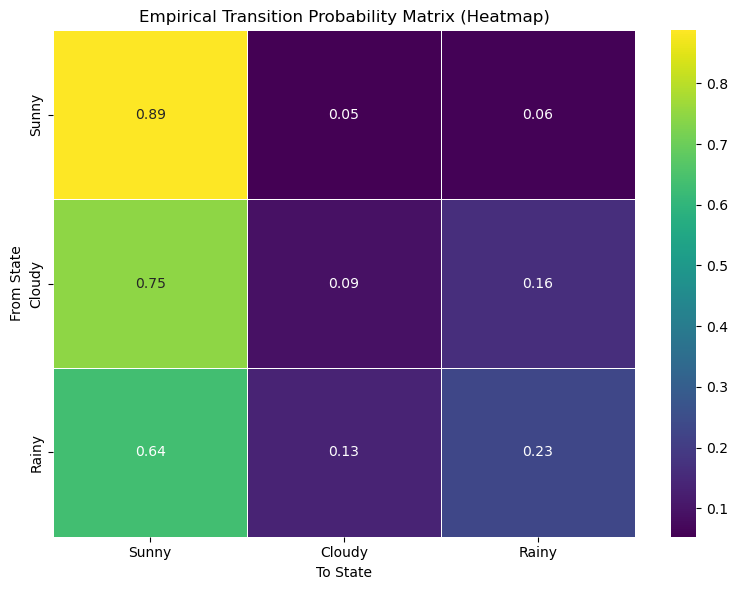

In [37]:
def transition_matrix_from_series(series: pd.Series) -> pd.DataFrame:
    """
    Create a transition matrix from a time series of states.

    Parameters
    ----------
    series (pd.Series): A pandas Series containing the states.

    Returns
    -------
    pd.DataFrame: A DataFrame representing the transition matrix.
    """
    # Shift series to get previous and current state pairs
    prev_states = series[:-1].values
    next_states = series[1:].values

    # Create a DataFrame of transitions
    transitions = pd.DataFrame({'from': prev_states, 'to': next_states})

    # Count occurrences of each transition
    counts = transitions.value_counts().unstack(fill_value=0)

    # Ensure all expected states are represented (optional, if `states` is predefined)
    counts = counts.reindex(index=states, columns=states, fill_value=0)

    # Convert counts to probabilities
    transition_probabilities = counts.div(counts.sum(axis=1), axis=0)

    return transition_probabilities

# Compute the empirical transition probability matrix from the training data
series = df_train['State']
transition_matrix = transition_matrix_from_series(series)

# Display the transition probability matrix
print("Transition Probability Matrix:")
print(transition_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Empirical Transition Probability Matrix (Heatmap)")
plt.xlabel("To State")
plt.ylabel("From State")
plt.tight_layout()
plt.show()

## Stationary distribution

We compute the stationary distribution of the Markov Chain, which represents the long-term behavior of the weather states. The stationary distribution is obtained by finding the eigenvector corresponding to the eigenvalue 1 of the transition matrix. We normalize this eigenvector to obtain the stationary distribution.

We will later use the stationary distribution to assess the quality of predictions that assume a constant transition probability matrix that is independent of the current state.

In [38]:
def stationary(transition_matrix: np.ndarray) -> np.ndarray:
    """
    Calculate the stationary distribution of a Markov chain given its transition matrix.
    Args:
        mat (numpy.ndarray): Transition matrix of the Markov chain.
    Returns:
        numpy.ndarray: Stationary distribution vector.
    """
    eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
    stationary_vector = eigvecs[:, np.isclose(eigvals, 1)]
    stationary_vector = stationary_vector[:, 0]
    stationary_distribution = stationary_vector / stationary_vector.sum()
    return stationary_distribution.real

# Calculate the stationary distribution
stationary_distribution = stationary(transition_matrix.values)

print("Stationary Distribution:")
for state, prob in zip(states, stationary_distribution):
    print(f"{state}\t{prob:.4f}")

Stationary Distribution:
Sunny	0.8584
Cloudy	0.0619
Rainy	0.0797


## Limiting distribution

The limiting distribution is computed by raising the transition matrix to a large power, which gives us the distribution of states after many transitions. This distribution is expected to converge to the stationary distribution.

We set a threshold for convergence, and we iterate until the difference between the current and previous distributions is below this threshold. This gives us the smallest power of the transition matrix that converges to the limiting distribution, essentially giving us an intuition of how many steps (days in our) are needed for the Markov Chain to reach a stable state.

In [39]:
def power_func(matrix: np.ndarray) -> int:
    """
    Find the smallest integer m such that P^m = P^(m+1) for a given transition matrix.
    Args:
        matrix (np.ndarray): Transition matrix of the Markov chain.
    Returns:
        int: The smallest integer m satisfying the condition.
    """
    for m in range(1, 1001):
        mat1 = np.round(np.linalg.matrix_power(matrix, m), decimals=9)
        mat2 = np.round(np.linalg.matrix_power(matrix, m + 1), decimals=9)
        if np.allclose(mat1, mat2, atol=0):
            return m

# Calculate the power
power = power_func(transition_matrix.values)
print(f"The smallest integer m such that P^m = P^(m+1) is: {power}")

P_lim = np.linalg.matrix_power(transition_matrix.values, power)
print("Limiting Matrix (P^m):")
print(P_lim)

The smallest integer m such that P^m = P^(m+1) is: 9
Limiting Matrix (P^m):
[[0.85841531 0.06188623 0.07969846]
 [0.85841458 0.06188645 0.07969896]
 [0.85841405 0.06188662 0.07969934]]


## Markov Chain simulation

We simulate the Markov Chain to generate weather predictions for a specified number of days. The simulation starts from a randomly randomly chosen state. We use the transition matrix to determine the next state based on the current state, and we repeat this process for the desired number of days.

Then, we use Frobenius norm to compare the simulated distribution with the stationary distribution over time, showing how the distribution evolves towards the stationary distribution as we simulate more days.

In [ ]:
# Fix the seed for reproducibility
np.random.seed(42)

# Initially distribute the states uniformly
uniform = [1/len(states)] * len(states)
print("Initial distribution:")
for state, prob in zip(states, uniform):
    print(f"{state}\t{prob:.4f}")

def markov(states: list[str], transition_matrix: np.ndarray, n_transitions: int, initial_state=None, initial_distribution=None):
    """
    Simulate a Markov chain given a transition matrix and an initial state or distribution.
    Args:
        states (list[str]): List of states in the Markov chain.
        transition_matrix (np.ndarray): Transition matrix of the Markov chain.
        n_transitions (int): Number of transitions to simulate.
        initial_state (int, optional): Initial state index to start the simulation. If None, uses initial distribution.
        initial_distribution (np.ndarray, optional): Initial distribution of states. If None, uses uniform distribution.
    Returns:
        list[str]: Simulated sequence of states.
    """
    # Use the provided initial state if given, otherwise use the initial distribution
    if initial_state is None:
        initial_state = np.random.choice(len(states), p=initial_distribution)
  
    # Initialize the simulation list
    sim_list = [initial_state] + [0] * n_transitions

    # Simulate the Markov chain (i.e., generate the next states based on the transition matrix)
    for i in range(1, n_transitions):
        state = sim_list[i - 1]
        # Choose the next state based on the transition probabilities from the previous state
        sim_list[i] = np.random.choice(len(states), p=transition_matrix[state])
    
    # Return the simulated states
    return [states[i] for i in sim_list]

# Transition matrix
P_matrix = transition_matrix.values

sim_series = markov(states, P_matrix, 1000, initial_distribution=uniform)

# Relative frequency distribution
sim_frequency_distribution = pd.Series(sim_series).value_counts(normalize=True)
print("\nRelative frequency distribution:")
print(sim_frequency_distribution)

Initial distribution:
Sunny	0.3333
Cloudy	0.3333
Rainy	0.3333

Relative frequency distribution:
Sunny     0.843157
Rainy     0.082917
Cloudy    0.073926
Name: proportion, dtype: float64


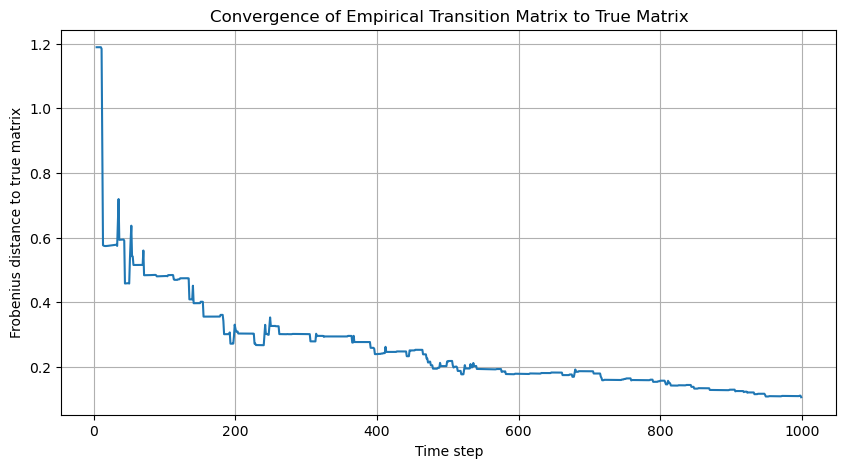

In [43]:
# Initialize a list to store Frobenius distances
frobenius_dists = []

series = pd.Series(sim_series)

# Compute empirical transition matrix at each step
for t in range(1, len(series)):
    # Convert counts to probabilities
    empirical_probs = transition_matrix_from_series(series[0:t])
    # Compute Frobenius norm (Euclidean distance between matrices)
    dist = np.linalg.norm(empirical_probs - P_matrix, ord='fro')
    frobenius_dists.append(dist)

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(frobenius_dists)
plt.xlabel('Time step')
plt.ylabel('Frobenius distance to true matrix')
plt.title('Convergence of Empirical Transition Matrix to True Matrix')
plt.grid(True)
plt.show()

## Ranked Probability Score (RPS)

We use the initial state from the test dataset and simulate the Markov chain up to the length of the test dataset. We then compute the Ranked Probability Score (RPS) to evaluate the accuracy of our predictions. We compare the RPS using three different methods:
1. **Empirical transition probabilities:** Using the transition matrix derived from the training data.
2. **Stationary distribution:** Assuming the stationary distribution as the transition probabilities.
3. **Uniform distribution:** Using a uniform distribution as the transition probabilities.

We observe that using the empirical transition probabilities yields the best RPS, with the stationary distribution performing slightly worse (since it only considers the long-term behavior of the system), and the uniform distribution performing the worst.

Ranked Probability Score (RPS)
	Using empirical transition distribution: 0.1282
	Using stationary distribution:           0.1921
	Using uniform distribution:              0.5327


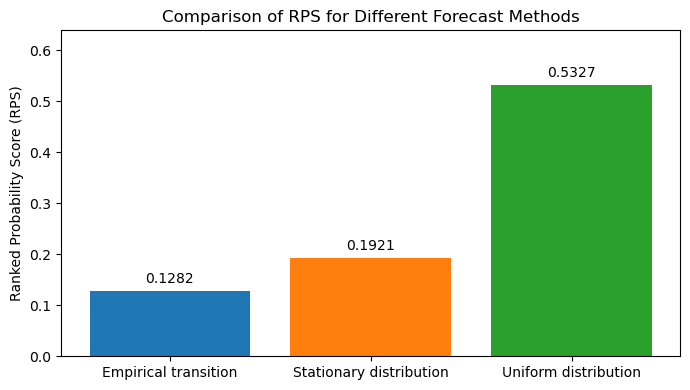

In [47]:
def ranked_probability_score(forecasts: np.ndarray, observations: np.ndarray) -> float:
    """
    Calculate the Ranked Probability Score (RPS) for categorical forecasts.
    
    Parameters:
    -----------
    forecasts : np.ndarray
        2D array where each row is a forecast and each column represents
        the probability of each category. Shape: (n_forecasts, n_categories)
        Each row should sum to 1.0
    observations : np.ndarray
        1D array of observed category indices (0-based) or 2D array of one-hot
        encoded observations. Shape: (n_forecasts,) or (n_forecasts, n_categories)
    
    Returns:
    --------
    float : The mean Ranked Probability Score
    """
    # Convert observations to one-hot encoding (e.g. [1, 0, 0] for 0, [0, 0, 1] for 2, etc.)
    observations_onehot = pd.get_dummies(observations).astype(int).values
    
    # Calculate cumulative probabilities for each forecast and observation
    forecast_cumsum = np.cumsum(forecasts, axis=1)
    obs_cumsum = np.cumsum(observations_onehot, axis=1)
    
    # The RPS of each forecast and observation pair is the sum of squared differences of cumulative probabilities
    # We exclude the last category as it's always 1.0 for both
    rps_scores = np.sum((forecast_cumsum[:, :-1] - obs_cumsum[:, :-1]) ** 2, axis=1)

    # Average the RPS scores across all forecasts
    return np.mean(rps_scores)

# The observations are the ordinals of the state in each sample in the test set
observations = np.array([states.index(state) for state in df_test['State']])

print("Ranked Probability Score (RPS)")

# Create forecasts for the test set based on the transition matrix
forecasts = np.array([P_matrix[states.index(state)] for state in df_test['State']])
rps_score = ranked_probability_score(forecasts, observations)

# Try again with the stationary distribution as the forecast
forecasts_stationary = np.tile(stationary_distribution, (len(df_test), 1))
rps_score_stationary = ranked_probability_score(forecasts_stationary, observations)

# Now try with a uniform distribution
forecasts_uniform = np.tile(np.array(uniform), (len(df_test), 1))
rps_score_uniform = ranked_probability_score(forecasts_uniform, observations)

print(f"\tUsing empirical transition distribution: {rps_score:.4f}")
print(f"\tUsing stationary distribution:           {rps_score_stationary:.4f}")
print(f"\tUsing uniform distribution:              {rps_score_uniform:.4f}")

methods = [
    "Empirical transition",
    "Stationary distribution",
    "Uniform distribution"
]
rps_values = [
    rps_score,
    rps_score_stationary,
    rps_score_uniform
]

# Plot the RPS values
plt.figure(figsize=(7, 4))
bars = plt.bar(methods, rps_values, color=['C0', 'C1', 'C2'])
plt.ylabel("Ranked Probability Score (RPS)")
plt.title("Comparison of RPS for Different Forecast Methods")
plt.ylim(0, max(rps_values) * 1.2)

# Annotate bars with values
for bar, value in zip(bars, rps_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{value:.4f}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()